# Facultad de Ciencias, UNAM.
# Proyecto Redes Neuronales:

## Clasificador de géneros musicales

### Integrantes:
- Jorge Francisco Cortés López - 314330981
- Sandra del Mar Soto Corderi - 3157070267

## Introducción y motivación.
#TODO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
device = "cpu"

# Procesamiento de datos
Lo primero que hacemos es cargar los datos con ayuda de la biblioteca pandas, que es de mucha utilidad para cargar y manipular datos en python. Mostramos un sample de los datos.

In [5]:
music_data = 'data/musicdata.csv'
music_data = pd.read_csv(music_data)
music_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


## Limpieza de datos
Vemos si existen canciones duplicadas en diferentes géneros, en éste caso hay canciones que están en varios géneros, por lo que lo mejor será quitarlas.

In [6]:
music_data = music_data.drop_duplicates(subset=['track_name'], keep='first', ignore_index=True)

Quitamos también las características que no nos interesan, en éste caso: 

artist_name, track_name, track_id, duration_ms

no nos interesan, ya que ésto en un principio no tendría porqué influenciar el género de una canción.

In [7]:
unused_col = ['artist_name', 'track_name', 'track_id', 
              'duration_ms']
music_data = music_data.drop(columns=unused_col)
music_data.head()

,genre,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0,0.611,0.389,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,1,0.246,0.590,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,3,0.952,0.663,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,0,0.703,0.240,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,4,0.950,0.331,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


Finalmente, vemos si hay ejemplares que tengan algún dato faltante.

In [8]:
music_data.isna().sum().sum()

0

## Codificación y normalización
Una vez que nuestros datos están limpios podemos hacer la codificación para nuestra red neuronal, vamos que hay algunos que necesitan ser normalizados como popularity, loudness y tempo. Sin embargo también vemos que key, mode y time signature necesitan ser codificados.

In [9]:
# Normalizamos las columnas correspondientes.
mms = MinMaxScaler()
music_data[['popularity','tempo']] = \
            mms.fit_transform(music_data[['popularity','tempo']])
music_data.head()

,genre,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0.00,0.611,0.389,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,0.642704,4/4,0.814
1,Movie,0.01,0.246,0.590,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,0.675801,4/4,0.816
2,Movie,0.03,0.952,0.663,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,0.325182,5/4,0.368
3,Movie,0.00,0.703,0.240,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,0.665238,4/4,0.227
4,Movie,0.04,0.950,0.331,0.225,0.123,F,0.2020,-21.150,Major,0.0456,0.518516,4/4,0.390


In [10]:
# Codificamos a One hot encoding las columnas necesarias.
music_data = \
    pd.get_dummies(data=music_data, columns=['key', 'mode', 'time_signature'], dtype=float)
music_data.head()

,genre,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_F#,key_G,key_G#,mode_Major,mode_Minor,time_signature_0/4,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4
0,Movie,0.00,0.611,0.389,0.910,0.000,0.3460,-1.828,0.0525,0.642704,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Movie,0.01,0.246,0.590,0.737,0.000,0.1510,-5.559,0.0868,0.675801,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Movie,0.03,0.952,0.663,0.131,0.000,0.1030,-13.879,0.0362,0.325182,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Movie,0.00,0.703,0.240,0.326,0.000,0.0985,-12.178,0.0395,0.665238,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Movie,0.04,0.950,0.331,0.225,0.123,0.2020,-21.150,0.0456,0.518516,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Luego de codificar y normalizar los ejemplares, aplicamos codificamos igualmente las clases con ayuda de la clase LabelEncoder.

In [11]:
le = LabelEncoder()
music_data['genre'] = le.fit_transform(music_data.genre.values).astype(float)
music_data.head()

,genre,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_F#,key_G,key_G#,mode_Major,mode_Minor,time_signature_0/4,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4
0,15.0,0.00,0.611,0.389,0.910,0.000,0.3460,-1.828,0.0525,0.642704,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,15.0,0.01,0.246,0.590,0.737,0.000,0.1510,-5.559,0.0868,0.675801,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,15.0,0.03,0.952,0.663,0.131,0.000,0.1030,-13.879,0.0362,0.325182,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,15.0,0.00,0.703,0.240,0.326,0.000,0.0985,-12.178,0.0395,0.665238,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,15.0,0.04,0.950,0.331,0.225,0.123,0.2020,-21.150,0.0456,0.518516,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Finalmente vemos cómo quedaron las columnas de los datos ya procesados y limpios para proseguir con los demás pasos

In [12]:
music_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148615 entries, 0 to 148614
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   genre               148615 non-null  float64
 1   popularity          148615 non-null  float64
 2   acousticness        148615 non-null  float64
 3   danceability        148615 non-null  float64
 4   energy              148615 non-null  float64
 5   instrumentalness    148615 non-null  float64
 6   liveness            148615 non-null  float64
 7   loudness            148615 non-null  float64
 8   speechiness         148615 non-null  float64
 9   tempo               148615 non-null  float64
 10  valence             148615 non-null  float64
 11  key_A               148615 non-null  float64
 12  key_A#              148615 non-null  float64
 13  key_B               148615 non-null  float64
 14  key_C               148615 non-null  float64
 15  key_C#              148615 non-nul

## División del conjunto de datos
Una vez que hemos limpiado el conjunto de datos proseguimos a hacer la división en los conjuntos de entrenamiento y prueba.

In [13]:
Y = music_data.pop('genre')
X = music_data

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.3,random_state=7, stratify=Y)

# Clase de dataset para Pytorch
Una vez que ya tenemos los datos separados, creamos la clase que hereda de Dataset en pytorch para facilitar el flujo entre la red neuronal y poder hacer el entrenamiento en lotes (batches).

In [15]:
class MusicDataset(Dataset):
    """Dataset de música de spotify"""
    
    def __init__(self, X, Y):
        """
        Args:
            X (pandas DataFrame): Datos.
            Y (pandas DataFrame): Labels.
        """
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        features = np.asarray(self.X.iloc[idx])
        label = np.asarray(self.Y.iloc[idx])
        return features, label

## Instancias de objetos de datos para pytorch
Una vez creada la clase para los datos de música, los instanciamos con el conjunto de entrenamiento y de prueba para pytorch como DataLoader.

In [16]:
# Entrenamiento:
trainset = MusicDataset(X = X_train, Y = y_train)
trainset = DataLoader(trainset, batch_size=20000) # Podemos cambiar el número de lotes.

# Prueba:
testset = MusicDataset(X = X_test, Y = y_test)
testset = DataLoader(testset, batch_size=5000)

# Modelo
Ya teniendo los datos como DataLoader ahora nos enfocamos en el modelo.

En éste proyecto decidimos utilizar la arquitectura de perceptrón multicapa, a continuación definimos el modelo y posteriormente haremos el entrenamiento de la red.
Tenemos: 29 características de entrada y 27 de salida (27 géneros en total)

In [17]:
class Musica(nn.Module):
    def __init__(self,input_size,hidden,output_size):
        '''
        Define las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Musica,self).__init__()
        #Declaramos las tres capas 
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output_size) 
        # Función de error.
        self.loss_fn = nn.CrossEntropyLoss()
        # Algoritmo de optimización.
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        # Error actual de la red.
        self.loss = 0.0
        
    def forward(self,X):
        '''
        Define una función que de como resultado realizar la propagación
        hacia adelante de los elementos de X en la red definida.
        '''
        #Se activa la capa de entrada
        X = self.fc1(X)
        #Se usa relu para activar las capas, ya que funciona como una función de activación unitaria
        X = F.relu(X)
        #Se activa la capa oculta
        X = self.fc2(X)
        X = F.relu(X)
        #Se activa la capa de salida
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
        
    def back_propagate(self,X,Y):
        '''
        Define una función que realice la propagación hacia atras usando 
        la función de error de entropia cruzada.
        '''
        # Calculamos el error.
        self.loss = self.loss_fn(X,Y.long())
        
        #Vaciamos los gradientes, hacemos una propagación hacia atrás
        # y actualizamos pesos.
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        
    def train(self,train_X,ciclos=100):
        '''
        Define una función de entrenamiento para la red, la cual utilice
        al conjunto de entrenamiento y el algoritmo de optimización que se 
        obtenga como parametro. Al finalizar los ciclos muestra la gráfica 
        del error.
        '''
        data_error = np.zeros(ciclos)
        
        for t in range(ciclos):
            # Para cada uno de los lotes.
            for data in train_X:
                X, Y = data
                X, Y = X.to(device), Y.to(device)
                
                # Feed forward.
                y_pred = self(X.float())
                
                # Back propagate.
                self.back_propagate(y_pred, Y)
                
                # Anexamos el error actual.
                data_error[t] = self.loss
            print("Error en la iteración: " + str(t) + " " + str(self.loss))
        
        # Graficamos el error.
        if ciclos > 1:
            plt.plot(np.arange(ciclos), data_error)
            plt.xlabel('Iteraciones')
            plt.ylabel('Error')
                
    def confusion(self,dataset,numClases):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        # Matriz de confusión inicial con dimensión correspondiente al número de clases.
        cmatrix = np.zeros([numClases,numClases], dtype=int)
        for data in dataset:
            X,Y = data
            #Se obtienen las predicciones de la data
            y_pred = self.forward(X.float())
            _, predicted = torch.max(y_pred.data, 1)
            # Se juntan los datos para obtener predicciones de las clases.
            stacked = torch.stack((predicted ,Y),dim=1)
            # Iteramos sobre las predicciones y las clases.
            for p in stacked:
                tl, pl = p.tolist()
                cmatrix[int(tl), int(pl)] = cmatrix[int(tl), int(pl)] + 1
        # Una vez calculada la matriz se grafica
        music_labels = music_data['genre'].unique() 
        df_cm = pd.DataFrame(cmatrix, index = music_labels, columns = music_labels)
        plt.figure(figsize = (20,15))
        sns.set_theme(style="whitegrid")
        #Por cuestiones de estética y facilidad se usa heatmap
        sns.heatmap(df_cm, annot=True, robust=True, fmt="d", cmap="YlGnBu")
        plt.title("Matriz de confusión sin normalizar")
        plt.ylabel('Predicción')
        plt.xlabel('Actual')
        plt.show()
        
    # Accuracy de un conjunto de datos dentro de la RN.
    def accurNet(self, dataTest):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in dataTest:
                X, Y = data

                y_pred = self.forward(X.float())

                _, predicted = torch.max(y_pred.data, 1)
                predicted = predicted.float()
                total += Y.size(0)
                correct += (predicted == Y).sum().item()
        return 100 * correct / total

In [18]:
# Instanciamos la red.
nn_Musica = Musica(29, 50, 27)
#nn_Musica.cuda() # Para cuda.

Error en la iteración: 0 tensor(3.2290, grad_fn=<NllLossBackward>)
Error en la iteración: 1 tensor(3.1693, grad_fn=<NllLossBackward>)
Error en la iteración: 2 tensor(3.1172, grad_fn=<NllLossBackward>)
Error en la iteración: 3 tensor(3.0723, grad_fn=<NllLossBackward>)
Error en la iteración: 4 tensor(3.0312, grad_fn=<NllLossBackward>)
Error en la iteración: 5 tensor(2.9919, grad_fn=<NllLossBackward>)
Error en la iteración: 6 tensor(2.9496, grad_fn=<NllLossBackward>)
Error en la iteración: 7 tensor(2.9060, grad_fn=<NllLossBackward>)
Error en la iteración: 8 tensor(2.8635, grad_fn=<NllLossBackward>)
Error en la iteración: 9 tensor(2.8252, grad_fn=<NllLossBackward>)
Error en la iteración: 10 tensor(2.7929, grad_fn=<NllLossBackward>)
Error en la iteración: 11 tensor(2.7634, grad_fn=<NllLossBackward>)
Error en la iteración: 12 tensor(2.7331, grad_fn=<NllLossBackward>)
Error en la iteración: 13 tensor(2.7023, grad_fn=<NllLossBackward>)
Error en la iteración: 14 tensor(2.6709, grad_fn=<NllLossB

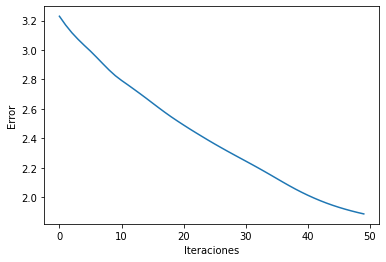

In [19]:
nn_Musica.train(trainset, ciclos=50

In [20]:
nn_Musica.accurNet(trainset)

41.635105258098626